# Import Libraries

In [ ]:
# Import libraries
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from collections import defaultdict
from numpy.random import seed
from PIL import Image
from tqdm.notebook import tqdm
seed(1)
warnings.filterwarnings('ignore')
%matplotlib inline

# Load the dataset

In [ ]:
# load datasets
X_train = np.load('/content/drive/MyDrive/train/trnImage.npy')
X_test = np.load('/content/drive/MyDrive/test/tstImage.npy')
y_train = np.load('/content/drive/MyDrive/train/trnLabel_coarse.npy')
y_test = np.load('/content/drive/MyDrive/test/tstLabel_coarse.npy')

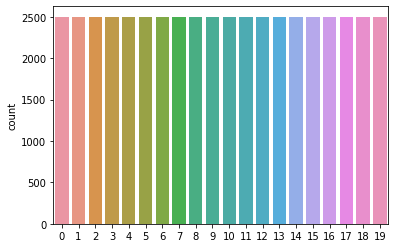

In [ ]:
# check if dataset is balanced
sns.countplot(y_train)

*There is no need to upsample the dataset since its balanced*

In [ ]:
# a function for plotting the confusion matrix
def confusion_matrix(y_true, y_pred, title):
  targets = y_true
  predictions = y_pred
  df = pd.DataFrame({"targets":targets,"predictions":predictions})
  df["targets"] = df["targets"]
  df["predictions"] = df["predictions"]
  df = pd.crosstab(df["targets"],df["predictions"])
  plt.figure(figsize=(13,10))
  sns.heatmap(df , cmap="Blues",annot=True,fmt=".2f")
  plt.title(f"{title} Test Confusion Marix")
  plt.savefig(f"{title} Test Confusion Marix")
  plt.show() 

 # First Model: MLP

In [ ]:
# Import neccessary libraries needed here
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# a function to help convert image to 1D
def ImageTo1D(data):
  data_flat = []
  size = data.shape[-1]
  for idx in range(size):
      data_flat.append(data[:, :, :, idx].flatten())
  return np.array(data_flat)

In [ ]:
new_X_train = ImageTo1D( X_train )
new_X_test = ImageTo1D( X_test )

# data shape
print(new_X_train.shape, new_X_test.shape)

(50000, 3072) (10000, 3072)


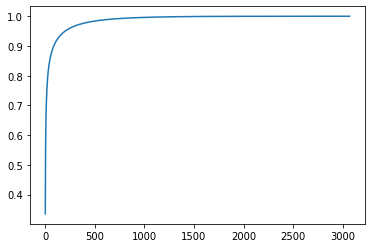

In [ ]:
# Apply PCA to reduce the dimensionality of the training dataset
train_pca = PCA(whiten=True, random_state=42)
train_pca.fit(new_X_train)

# plot the pca variance ratio to guide how many n_components to choose
plt.plot(np.cumsum(train_pca.explained_variance_ratio_))

In [ ]:
# the data will still retain its originality if 1000 components is used
pca = PCA(n_components=1000, random_state=42, whiten=True)
X_train_pca = pca.fit_transform(new_X_train)
X_test_pca = pca.transform(new_X_test)

In [ ]:
# instantiate the mlp model and fit on the training set
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_pca, y_train)
mlp_pred = mlp.predict(X_test_pca)

# model accuracy score
print('MLP Accuracy: ', accuracy_score(y_test, mlp_pred)*100)

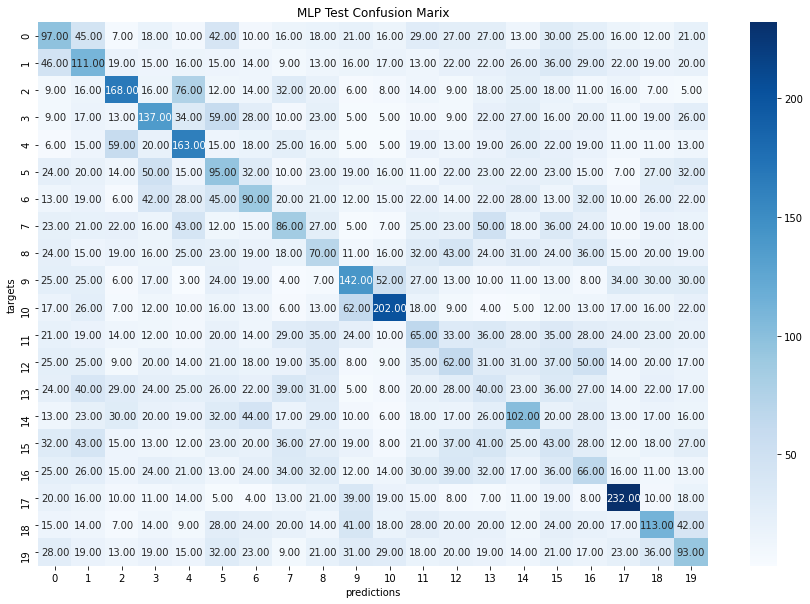

In [ ]:
# a function for plotting the confusion matrix
def confusion_matrix(y_true, y_pred, title):
  targets = y_true
  predictions = y_pred
  df = pd.DataFrame({"targets":targets,"predictions":predictions})
  df["targets"] = df["targets"]
  df["predictions"] = df["predictions"]
  df = pd.crosstab(df["targets"],df["predictions"])
  plt.figure(figsize=(15 ,10))
  sns.heatmap(df , cmap="Blues",annot=True,fmt=".2f")
  plt.title(f"{title} Test Confusion Marix")
  plt.savefig(f"{title} Test Confusion Marix")
  plt.show() 

# confusion matrix
confusion_matrix(y_test, mlp_pred, 'MLP')

*Applying PCA on the dataset and training a multilayer perceptron on it gives an overral accuracy score of 21.77%* 

# Support vector machine

In [ ]:
# download svm with gpu support
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

!nvcc --version
!pip install thundersvm

SVM Accuracy Score:  0.2895


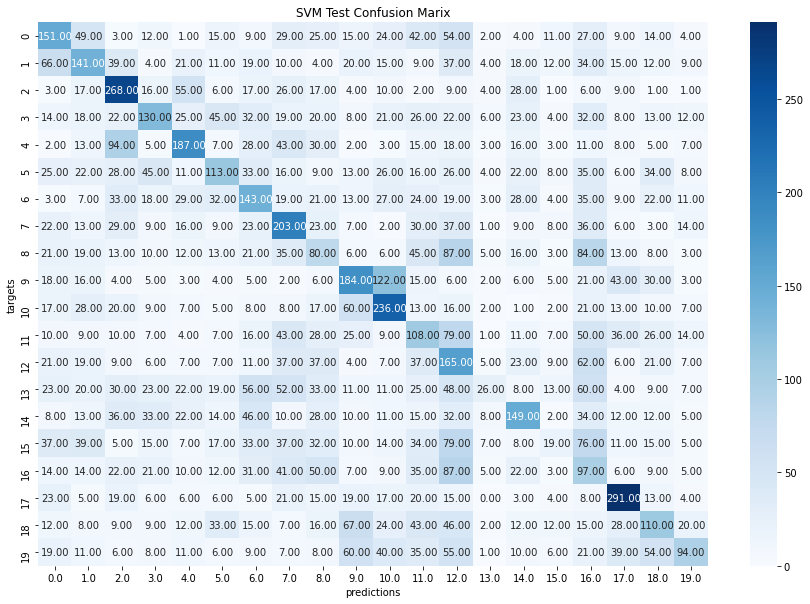

In [ ]:
# import Library
from thundersvm import SVC
svm = SVC()
svm.fit(new_X_train, y_train)
svm_pred = svm.predict(new_X_test)

# svm accuracy score
print('SVM Accuracy Score: ', accuracy_score(y_test, svm_pred))

# confusison matrix
confusion_matrix(y_test, svm_pred, 'SVM')

# Convolutional Neural Network

In [ ]:
# custom dataset class
class CIFARDataset(Dataset):
    def __init__(self, images=None, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        labels = self.labels[index]

        if self.transform is not None:
          image = self.transform(image)
        return image, labels

In [ ]:
# define some utility functions
def convertToPil(numpy_images):
    pil_image = []
    size = numpy_images.shape[-1]
    for i in range(size):
        img = numpy_images[:, :, :, i]
        img = Image.fromarray(np.uint8(img*255))
        pil_image.append(img)
    return pil_image
  
def train_val_split(X, y, val_size):
    X_size = X.shape[-1]
    indices = list(range(X_size))
    np.random.shuffle(indices)
    split = int(np.floor(val_size * X_size))
    train_idx, val_idx = indices[split:], indices[:split]
    X = X.transpose(3,0,1,2)
    X_train = X[train_idx].transpose(1,2,3,0)
    X_val = X[val_idx].transpose(1,2,3,0)
    y_train = y[train_idx]
    y_val = y[val_idx]
    return X_train, X_val, y_train, y_val

In [ ]:
# Data Augumentation
train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor()
                                ])
 
val_transform = transforms.Compose([
                                transforms.ToTensor()
                                ])

# Transform Dataset
X_train, X_val, y_train, y_val = train_val_split(X_train, y_train, 0.2)
X_train = convertToPil(X_train)
X_test = convertToPil(X_test)
X_val = convertToPil(X_val)

In [ ]:
# Load datasets with the custom class
training = CIFARDataset(X_train, y_train, transform=train_transform)
validation = CIFARDataset(X_val, y_val, transform=val_transform)
testing = CIFARDataset(X_test, y_test, transform=val_transform)

# Dataloader
train_loader = DataLoader(training, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation, batch_size=32, shuffle=True)
testing_loader = DataLoader(testing, batch_size=32)

images.shape:  torch.Size([32, 3, 32, 32])


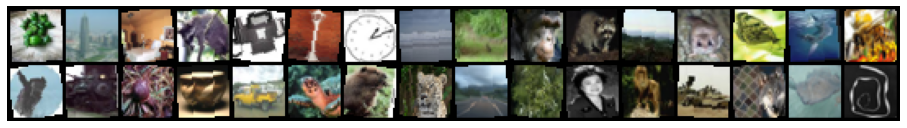

In [ ]:
# Image Visualization
for images, labels in train_loader:
    print('images.shape: ', images.shape)
    plt.figure(figsize=(16, 4))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
# Model
class CifarObjectClassification(nn.Module):
  def __init__(self):
        super(CifarObjectClassification, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=2, stride=2)
        self.norm1 = nn.BatchNorm2d(96, affine=True, momentum=0.99, eps=1e-3)
        self.conv2 = nn.Conv2d (96, 256, kernel_size=2, stride=2)
        self.norm2 = nn.BatchNorm2d(256, affine=True, momentum=0.99, eps=1e-3)
        self.conv2_drop = nn.Dropout2d(p=0.1)
        self.fc3 = nn.Linear(256*2*2, 1500)
        self.norm3 = nn.BatchNorm1d(1500, momentum=0.99, eps=1e-3, affine=True)
        self.fc4 = nn.Linear(1500, 1000)
        self.norm4 = nn.BatchNorm1d(1000, momentum=0.99, eps=1e-3)
        self.out = nn.Linear(1000, 20)

  def forward(self, x):
        x = self.norm1(F.relu(F.max_pool2d(self.conv1(x.float()), 2)))
        x = self.norm2(F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)))
        x = x.view(x.size(0), -1)
        x = self.norm3(F.relu(self.fc3(x)))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.norm4(F.relu(self.fc4(x)))
        x = F.dropout(x, training=self.training, p=0.1)
        x = F.relu(self.out(x))
        return F.log_softmax(x, dim=1)

In [ ]:
class TrainModel:
  def __init__(self, model, optimizer, criterion):
    self.model = model.to(device)
    self.optimizer = optimizer
    self.criterion = criterion

  def train(self, data_loader):
    running_correct = 0.0
    running_loss = 0.0

    for data, label in data_loader:
      torch.cuda.empty_cache()
      if torch.cuda.is_available():
        data, label = data.cuda(), label.cuda()
      
      self.optimizer.zero_grad()
      model = self.model.train()
      output = model(data)
      loss = self.criterion(output, label)
      preds = output.data.max(dim=1, keepdim=True)[1]
      running_correct += preds.eq(label.data.view_as(preds)).cpu().sum()
      running_loss += self.criterion(output, label).item()

      loss.backward()
      optimizer.step()

      loss = running_loss / len(data_loader.dataset)
      accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'training loss is {loss:{5}.{2}} and training accuracy is \
    {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss, accuracy

  def validate(self, data_loader):
    running_correct = 0.0
    running_loss = 0.0

    with torch.no_grad():
      for data, label in data_loader:
        torch.cuda.empty_cache()
        if torch.cuda.is_available():
          data, label = data.cuda(), label.cuda()
        model = self.model.eval()
        output = model(data)
        loss = self.criterion(output, label)
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(label.data.view_as(preds)).cpu().sum()
        running_loss += self.criterion(output, label).item()

        loss = running_loss / len(data_loader.dataset)
        accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'validation loss is {loss:{5}.{2}} and validation accuracy is \
    {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss, accuracy
        

In [ ]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print(f"GPU is available!.\nGPU's Type: {torch.cuda.get_device_name()}")
else:
  print("GPU isn't available!")

GPU is available!.
GPU's Type: Tesla T4


In [ ]:
model = CifarObjectClassification()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
trainer = TrainModel(model, optimizer, criterion)
epochs = 15
history = defaultdict(list)
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch+1}/{epochs}')
    train_loss, train_accuracy = trainer.train(train_loader) 
    val_loss, val_accuracy = trainer.validate(validation_loader)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(val_loss)

Epoch 1/15
training loss is 0.077 and training accuracy is     10252.0/(40000     25.63
validation loss is 0.071 and validation accuracy is     3306.0/(10000     33.06
Epoch 2/15
training loss is 0.069 and training accuracy is     13153.0/(40000     32.88
validation loss is 0.068 and validation accuracy is     3513.0/(10000     35.13
Epoch 3/15
training loss is 0.065 and training accuracy is     14504.0/(40000     36.26
validation loss is 0.065 and validation accuracy is     3805.0/(10000     38.05
Epoch 4/15
training loss is 0.063 and training accuracy is     15369.0/(40000     38.42
validation loss is 0.062 and validation accuracy is     4012.0/(10000     40.12
Epoch 5/15
training loss is 0.061 and training accuracy is     16193.0/(40000     40.48
validation loss is 0.059 and validation accuracy is     4250.0/(10000      42.5
Epoch 6/15
training loss is 0.059 and training accuracy is     16920.0/(40000      42.3
validation loss is 0.059 and validation accuracy is     4229.0/(10000   

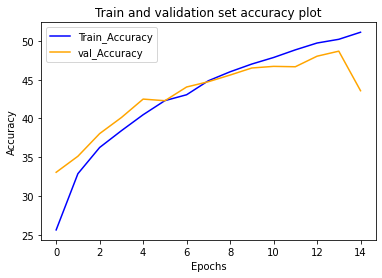

In [ ]:
# accuracy plot
plt.plot(history['train_accuracy'], color='blue', label='Train_Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Train and validation set accuracy plot')
plt.plot(history['val_accuracy'], color='orange', label='val_Accuracy')
plt.legend()
plt.savefig('Accuracy PLot')
plt.show()

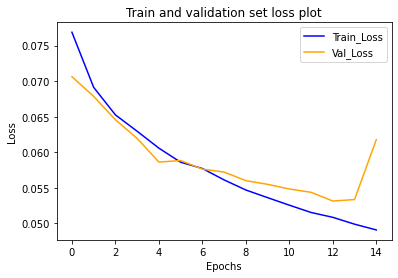

In [ ]:
# loss plot
plt.plot(history['train_loss'], color='blue', label='Train_Loss')
plt.plot(history['val_loss'], color='orange', label='Val_Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Train and validation set loss plot')
plt.legend()
plt.savefig('Loss PLot')
plt.show()

In [ ]:
def test_accuracy(model, criterion, data_loader):
  test_preds = []
  test_labels = []

  running_correct = 0.0
  running_loss = 0.0

  with torch.no_grad():
    for data, labels in data_loader:
      torch.cuda.empty_cache()
      model = model.eval()
      data, labels = data.to(device), labels.to(device)
      outputs = model(data)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, dim=1)
      
      test_preds.append(preds.cpu().numpy())
      test_labels.append(labels.cpu().numpy())

      running_correct += torch.sum(preds == labels)
      running_loss += loss.item()

  loss = running_loss / len(data_loader.dataset)
  accuracy = 100. * running_correct/len(data_loader.dataset)

  print(f'validation loss is {loss:{5}.{2}} and validation accuracy is \
  {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
  
  test_preds = np.concatenate(np.array(test_preds))
  test_labels = np.concatenate(np.array(test_labels))

  print('Accuracy score: ', accuracy_score(test_labels, test_preds)*100)
  return test_labels, test_preds

validation loss is 0.062 and validation accuracy is   4395.0/(10000     43.95
Accuracy score:  43.95


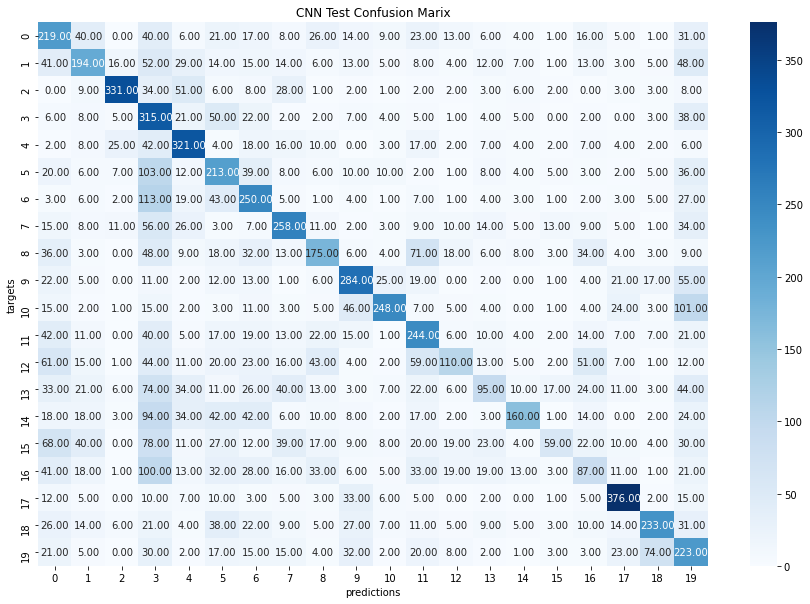

In [ ]:
labels, preds = test_accuracy(model, criterion, testing_loader)

# confusion matrix
confusion_matrix(labels, preds, 'CNN')

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/CIFAR_100(2).pt'
torch.save(model.state_dict(),  MODEL_PATH)